In [ ]:
# STEP 4: MULTIVARIATE ANALYSIS
print("\n=== Multivariate Analysis ===")

# Combine features (X) and target (y) into one dataframe for easier analysis
target_column = y.columns[0]
combined_df = pd.concat([X, y], axis=1)

# Get all feature names
all_features = X.columns.tolist()

# Group features by type (mean, SE, worst)
mean_features = [col for col in all_features if col.endswith('1')]
se_features = [col for col in all_features if col.endswith('2')]
worst_features = [col for col in all_features if col.endswith('3')]

# Group features by characteristic (radius, texture, etc.)
characteristics = ['radius', 'texture', 'perimeter', 'area', 'smoothness', 
                   'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension']

# Approach 1: Create pairplots by feature type (mean, SE, worst)
# Mean features pairplot
plt.figure(figsize=(15, 12))
sns.pairplot(combined_df[mean_features + [target_column]], hue=target_column, palette='viridis')
plt.suptitle('Pairwise Relationships - Mean Features by Diagnosis', y=1.02)
plt.savefig('pairplot_mean_features.png')
plt.show()

# SE features pairplot
plt.figure(figsize=(15, 12))
sns.pairplot(combined_df[se_features + [target_column]], hue=target_column, palette='viridis')
plt.suptitle('Pairwise Relationships - Standard Error Features by Diagnosis', y=1.02)
plt.savefig('pairplot_se_features.png')
plt.show()

# Worst features pairplot
plt.figure(figsize=(15, 12))
sns.pairplot(combined_df[worst_features + [target_column]], hue=target_column, palette='viridis')
plt.suptitle('Pairwise Relationships - Worst Features by Diagnosis', y=1.02)
plt.savefig('pairplot_worst_features.png')
plt.show()

# Approach 2: Create pairplots by characteristic groups
# This will show how a specific characteristic (e.g., radius) varies across different measurement types
for char in characteristics:
    # Get all features for this characteristic
    char_features = [col for col in all_features if col.startswith(char)]
    
    if len(char_features) >= 2:  # Need at least 2 features to make a pairplot
        plt.figure(figsize=(12, 10))
        sns.pairplot(combined_df[char_features + [target_column]], hue=target_column, palette='viridis')
        plt.suptitle(f'Pairwise Relationships - {char.capitalize()} Features by Diagnosis', y=1.02)
        plt.savefig(f'pairplot_{char}_features.png')
        plt.show()
        
# Approach 3: Create pairplots for top correlated features with target
# First, convert diagnosis to numeric for correlation calculation
combined_df['diagnosis_numeric'] = combined_df[target_column].map({'malignant': 0, 'benign': 1})

# Calculate correlation with target
corr_with_target = X.corrwith(combined_df['diagnosis_numeric']).abs().sort_values(ascending=False)

# Get top correlated features
top_correlated = corr_with_target.head(6).index.tolist()

# Create pairplot with top correlated features
plt.figure(figsize=(12, 10))
sns.pairplot(combined_df[top_correlated + [target_column]], hue=target_column, palette='viridis')
plt.suptitle('Pairwise Relationships - Top Correlated Features with Diagnosis', y=1.02)
plt.savefig('pairplot_top_correlated.png')
plt.show()

# Compare distributions of the same characteristic across different measurement types
for char in characteristics:
    # Get all features for this characteristic
    char_features = [col for col in all_features if col.startswith(char)]
    
    if char_features:  # Check if we found any matching features
        plt.figure(figsize=(15, 6))
        
        # Distribution plot
        plt.subplot(1, 2, 1)
        for feature in char_features:
            sns.kdeplot(combined_df[feature], label=feature)
        plt.title(f'Distribution of {char} (All measurements)')
        plt.legend()
        
        # Box plot by diagnosis
        plt.subplot(1, 2, 2)
        melted_data = pd.melt(combined_df[char_features + [target_column]], 
                             id_vars=[target_column], 
                             value_vars=char_features, 
                             var_name='measurement_type', 
                             value_name='value')
        sns.boxplot(x='measurement_type', y='value', hue=target_column, data=melted_data)
        plt.title(f'{char} by Measurement Type and Diagnosis')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.savefig(f'multivariate_{char}.png')
        plt.show()

# 3D scatter plot with three important features from different categories
# Select one important feature from each group based on correlation with target
top_mean = [f for f in corr_with_target.index if f.endswith('1')][:1][0]
top_se = [f for f in corr_with_target.index if f.endswith('2')][:1][0]
top_worst = [f for f in corr_with_target.index if f.endswith('3')][:1][0]

key_features_3d = [top_mean, top_se, top_worst]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Create color coding based on diagnosis
diagnosis_colors = combined_df[target_column].map({'malignant': 'red', 'benign': 'blue'})

# Create the 3D scatter plot
ax.scatter(
    combined_df[key_features_3d[0]], 
    combined_df[key_features_3d[1]], 
    combined_df[key_features_3d[2]], 
    c=diagnosis_colors,
    s=50,  # marker size
    alpha=0.7  # transparency
)

ax.set_xlabel(key_features_3d[0])
ax.set_ylabel(key_features_3d[1])
ax.set_zlabel(key_features_3d[2])

# Add a title and legend
plt.title('3D Visualization of Top Features from Each Category')

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Malignant', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Benign', markerfacecolor='blue', markersize=10)
]
ax.legend(handles=legend_elements, loc='upper right')

plt.savefig('3d_scatter_top_features.png')
plt.show()

# Create violin plots for key features by diagnosis
plt.figure(figsize=(18, 12))
# Select top 2 features from each category based on correlation
top_features = (
    [f for f in corr_with_target.index if f.endswith('1')][:2] +
    [f for f in corr_with_target.index if f.endswith('2')][:2] +
    [f for f in corr_with_target.index if f.endswith('3')][:2]
)

for i, feature in enumerate(top_features, 1):
    plt.subplot(2, 3, i)
    sns.violinplot(x=target_column, y=feature, data=combined_df, palette='Set2')
    plt.title(f'{feature} by Diagnosis')

plt.tight_layout()
plt.savefig('violin_plots_top_features.png')
plt.show()=

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from ucimlrepo import fetch_ucirepo

In [13]:
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 
  
# metadata 
print(breast_cancer_wisconsin_diagnostic.metadata) 
  
# variable information 
print(breast_cancer_wisconsin_diagnostic.variables)

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

In [15]:
# Create a composite score using multiple key features
combined_df = pd.concat([X, y], axis=1)
key_features = ['concave_points3', 'radius3', 'concavity3']

# Normalize each feature
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
combined_df[key_features] = scaler.fit_transform(combined_df[key_features])

# Create composite score
combined_df['composite_score'] = combined_df[key_features].mean(axis=1)

# Create 5 classes based on composite score
combined_df['class_id'] = pd.qcut(combined_df['composite_score'], 5, labels=False)

# Map to class labels
class_labels = {
    0: 'Very Low Risk',
    1: 'Low Risk',
    2: 'Moderate Risk', 
    3: 'High Risk',
    4: 'Very High Risk'
}

combined_df['diagnosis_class'] = combined_df['class_id'].map(class_labels)

Class distribution:
diagnosis_class
Very High Risk    114
High Risk         114
Low Risk          114
Very Low Risk     114
Moderate Risk     113
Name: count, dtype: int64


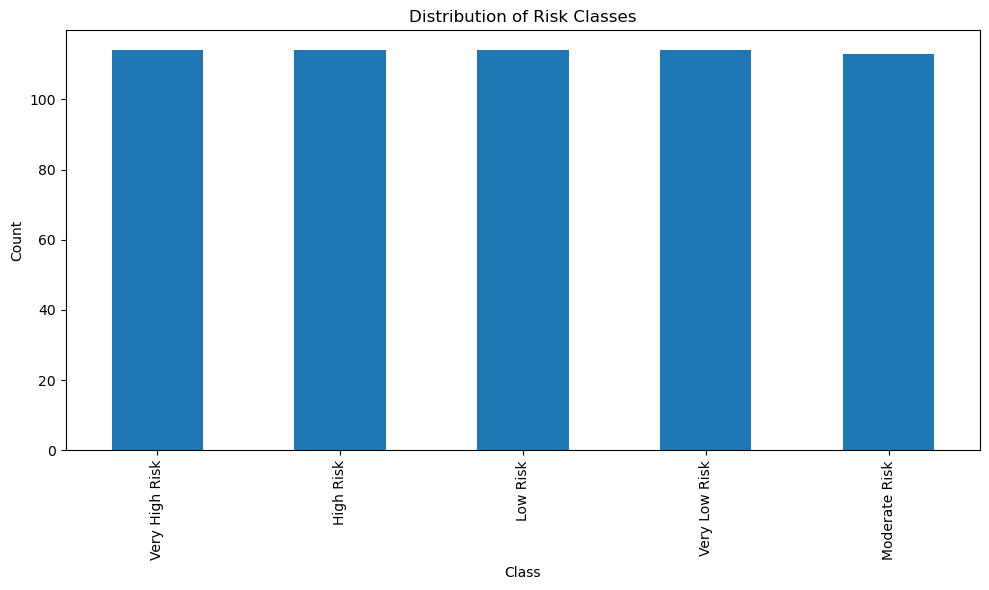


Percentage of malignant cases in each class:
diagnosis_class  Diagnosis
High Risk        M            0.771930
                 B            0.228070
Low Risk         B            0.991228
                 M            0.008772
Moderate Risk    B            0.920354
                 M            0.079646
Very High Risk   M            0.991228
                 B            0.008772
Very Low Risk    B            0.991228
                 M            0.008772
Name: proportion, dtype: float64


In [17]:
# Check class distribution
class_distribution = combined_df['diagnosis_class'].value_counts()
print("Class distribution:")
print(class_distribution)

# Visualize distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar')
plt.title('Distribution of Risk Classes')
plt.ylabel('Count')
plt.xlabel('Class')
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()

# Check alignment with original diagnosis
alignment = combined_df.groupby('diagnosis_class')[y.columns[0]].value_counts(normalize=True)
print("\nPercentage of malignant cases in each class:")
print(alignment)

In [34]:
# Feature Engineering and Selection for Breast Cancer Dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Assuming X contains all original features and y contains the diagnosis

# Step 1: Feature Normalization
# Normalize all numerical features using MinMaxScaler
print("Normalizing features...")
scaler = MinMaxScaler()
X_normalized = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns
)

# Step 2: Feature Engineering - Create new composite features
print("Engineering new features...")

# Group related features
size_features = ['radius', 'perimeter', 'area']
texture_features = ['texture']
shape_features = ['smoothness', 'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension']

# Create composite features based on our EDA insights
engineered_features = pd.DataFrame()

# Ratio features (comparing worst to mean measurements)
for feature in X.columns:
    if feature.endswith('3') and feature.replace('3', '1') in X.columns:
        base_name = feature[:-1]
        ratio_name = f"{base_name}ratio_worst_to_mean"
        engineered_features[ratio_name] = X_normalized[feature] / X_normalized[feature.replace('3', '1')]

# Difference features (worst - mean)
for feature in X.columns:
    if feature.endswith('3') and feature.replace('3', '1') in X.columns:
        base_name = feature[:-1]
        diff_name = f"{base_name}diff_worst_mean"
        engineered_features[diff_name] = X_normalized[feature] - X_normalized[feature.replace('3', '1')]

# Shape irregularity composite score
for suffix in ['1', '2', '3']:  # For each measurement type (mean, SE, worst)
    irregularity_features = [f for f in X.columns if f.endswith(suffix) and 
                           any(shape in f for shape in ['concavity', 'concave_points', 'compactness'])]
    
    if irregularity_features:
        engineered_features[f'irregularity_score{suffix}'] = X_normalized[irregularity_features].mean(axis=1)

# Size composite score
for suffix in ['1', '2', '3']:  # For each measurement type
    size_feat = [f for f in X.columns if f.endswith(suffix) and 
                any(size in f for size in ['radius', 'perimeter', 'area'])]
    
    if size_feat:
        engineered_features[f'size_score{suffix}'] = X_normalized[size_feat].mean(axis=1)

# Step 3: Feature Selection
# Based on our EDA, select the most relevant features
print("Selecting optimal feature sets...")

# Feature Set 1: All original features (normalized)
feature_set1 = X_normalized.copy()

# Feature Set 2: Only worst features (which showed best separation)
worst_features = [col for col in X.columns if col.endswith('3')]
feature_set2 = X_normalized[worst_features].copy()

# Feature Set 3: Top features identified in our correlation analysis
top_correlated_features = [
    'concave_points3', 'concavity3', 'radius3', 'perimeter3', 'area3', 
    'concave_points1', 'concavity1', 'radius1', 'perimeter1', 'area1'
]
feature_set3 = X_normalized[top_correlated_features].copy()

# Feature Set 4: One representative from each correlated group
# Choose one from each highly correlated group to reduce redundancy
representative_features = [
    'radius3',            # Representative of size features (worst)
    'texture3',           # Texture feature (worst)
    'concave_points3',    # Representative of boundary irregularity (worst)
    'symmetry3',          # Shape feature (worst)
    'fractal_dimension3', # Complexity feature (worst)
    'radius1',            # Representative of size features (mean)
    'concave_points1'     # Representative of boundary irregularity (mean)
]
feature_set4 = X_normalized[representative_features].copy()

# Feature Set 5: Engineered features only
feature_set5 = engineered_features.copy()

# Save all feature sets for model development
print("Feature engineering and selection complete.")
print(f"Feature Set 1: {feature_set1.shape[1]} features")
print(f"Feature Set 2: {feature_set2.shape[1]} features")
print(f"Feature Set 3: {feature_set3.shape[1]} features")
print(f"Feature Set 4: {feature_set4.shape[1]} features")
print(f"Feature Set 5: {feature_set5.shape[1]} features")

# Optionally, combine these with the original class labels for analysis
# combined_data = pd.concat([feature_set1, y], axis=1)

Normalizing features...
Engineering new features...
Selecting optimal feature sets...


KeyError: "None of [Index(['concave_points3', 'concavity3', 'radius3', 'perimeter3', 'area3',\n       'concave_points1', 'concavity1', 'radius1', 'perimeter1', 'area1'],\n      dtype='object')] are in the [columns]"

Training decision tree models...

Model: Decision Tree with All Original Features
Number of features: 30
Accuracy: 0.9006

Classification Report:
              precision    recall  f1-score   support

           B       0.91      0.93      0.92       107
           M       0.89      0.84      0.86        64

    accuracy                           0.90       171
   macro avg       0.90      0.89      0.89       171
weighted avg       0.90      0.90      0.90       171


Model: Decision Tree with Worst Features Only
Number of features: 10
Accuracy: 0.9591

Classification Report:
              precision    recall  f1-score   support

           B       0.95      0.98      0.97       107
           M       0.97      0.92      0.94        64

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171


Model: Decision Tree with Top Correlated Features
Number of features: 10
Accuracy: 0.918

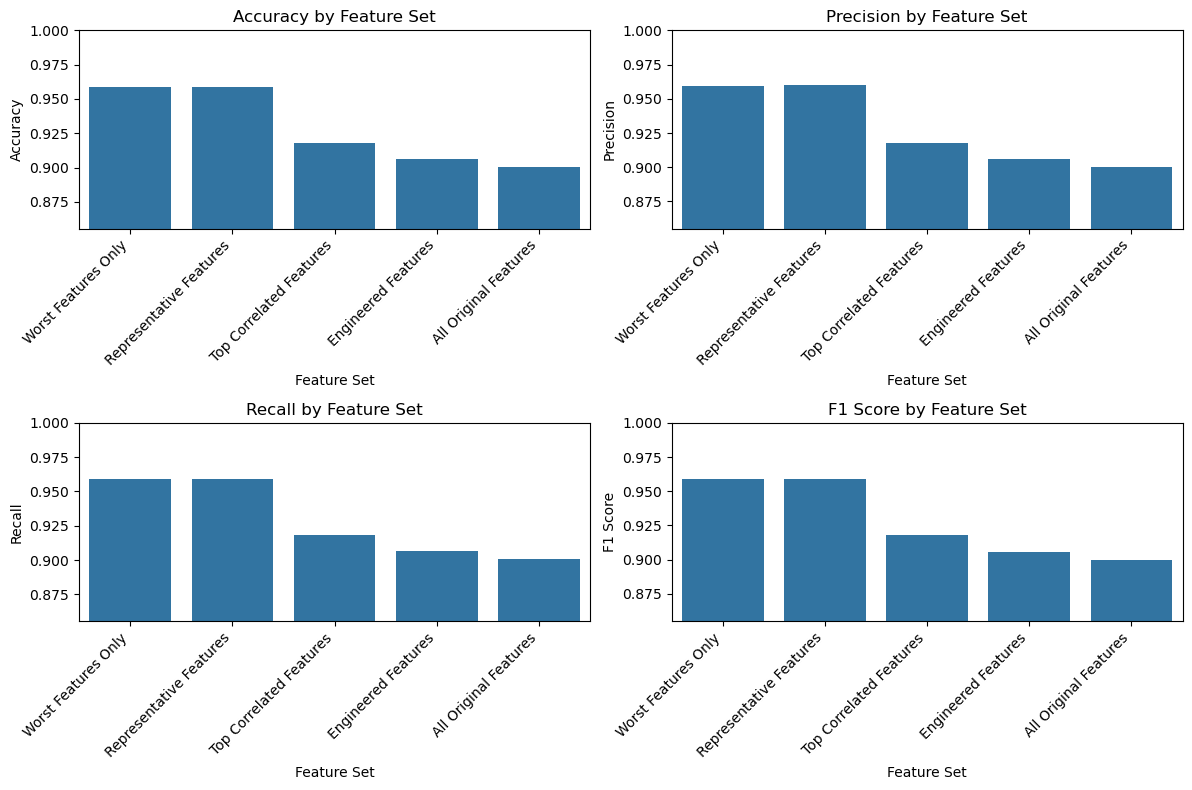


Model Performance Table (for portfolio document):
            Feature Set  Feature Count Accuracy Precision Recall F1 Score
    Worst Features Only             10   95.91%    95.93% 95.91%   95.89%
Representative Features              7   95.91%    96.01% 95.91%   95.87%
Top Correlated Features             10   91.81%    91.79% 91.81%   91.79%
    Engineered Features             26   90.64%    90.62% 90.64%   90.58%
  All Original Features             30   90.06%    90.02% 90.06%   90.01%


In [30]:
# Function to clean datasets of infinities
def clean_dataset(X):
    # Replace inf/-inf with NaN
    X_clean = X.copy()
    X_clean = X_clean.replace([np.inf, -np.inf], np.nan)
    
    # Then replace NaN with column mean
    col_means = X_clean.mean()
    for col in X_clean.columns:
        X_clean[col] = X_clean[col].fillna(col_means[col])
    
    return X_clean

# Clean all feature sets
X_sets = {
    'All Original Features': clean_dataset(feature_set1),
    'Worst Features Only': clean_dataset(feature_set2),
    'Top Correlated Features': clean_dataset(feature_set3),
    'Representative Features': clean_dataset(feature_set4),
    'Engineered Features': clean_dataset(feature_set5)
}

# Split data into training and testing sets (70-30 split)
random_state = 42  # For reproducibility
test_size = 0.3

# Dictionary to store results
results = {}

# Step 2: Train and evaluate decision tree models for each feature set
print("Training decision tree models...")

for name, X in X_sets.items():
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Initialize and train decision tree model
    dt_model = DecisionTreeClassifier(random_state=random_state)
    dt_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = dt_model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Store results
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'feature_count': X.shape[1],
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    # Print classification report
    print(f"\nModel: Decision Tree with {name}")
    print(f"Number of features: {X.shape[1]}")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

# Step 3: Create a comparison table
if results:  # Make sure we have results
    results_df = pd.DataFrame({
        'Feature Set': list(results.keys()),
        'Feature Count': [results[feature_set]['feature_count'] for feature_set in results],
        'Accuracy': [results[feature_set]['accuracy'] for feature_set in results],
        'Precision': [results[feature_set]['precision'] for feature_set in results],
        'Recall': [results[feature_set]['recall'] for feature_set in results],
        'F1 Score': [results[feature_set]['f1_score'] for feature_set in results]
    })

    # Sort by accuracy (descending)
    results_df = results_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

    # Display the comparison table
    print("\n=== Model Performance Comparison ===")
    print(results_df.to_string(index=False))

    # Step 4: Visualize the results
    plt.figure(figsize=(12, 8))

    # Bar chart for accuracy
    plt.subplot(2, 2, 1)
    sns.barplot(x='Feature Set', y='Accuracy', data=results_df)
    plt.title('Accuracy by Feature Set')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(max(0.7, results_df['Accuracy'].min() * 0.95), 1.0)  # Adjust based on results

    # Bar chart for precision
    plt.subplot(2, 2, 2)
    sns.barplot(x='Feature Set', y='Precision', data=results_df)
    plt.title('Precision by Feature Set')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(max(0.7, results_df['Precision'].min() * 0.95), 1.0)  # Adjust based on results

    # Bar chart for recall
    plt.subplot(2, 2, 3)
    sns.barplot(x='Feature Set', y='Recall', data=results_df)
    plt.title('Recall by Feature Set')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(max(0.7, results_df['Recall'].min() * 0.95), 1.0)  # Adjust based on results

    # Bar chart for F1 score
    plt.subplot(2, 2, 4)
    sns.barplot(x='Feature Set', y='F1 Score', data=results_df)
    plt.title('F1 Score by Feature Set')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(max(0.7, results_df['F1 Score'].min() * 0.95), 1.0)  # Adjust based on results

    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Format as a printable table
    print("\nModel Performance Table (for portfolio document):")
    formatted_df = results_df.copy()
    for col in ['Accuracy', 'Precision', 'Recall', 'F1 Score']:
        formatted_df[col] = formatted_df[col].apply(lambda x: f"{x:.2%}")
    print(formatted_df.to_string(index=False))